In [1]:
import pandas as pd
import glob
import math
import contractions
from nltk.corpus import stopwords
from nltk import word_tokenize
import keras
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten, Conv2D, Bidirectional
from keras.utils import plot_model, vis_utils
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import emoji
import string
from keras.callbacks import ModelCheckpoint

# Task 4 improving the models imports
import spacy



/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# Data has been preprocessed by removing all the " characters: sed -i 's/"//g' *.txt
# as this caused issues reading the data as a csv file. 
# Also had to remove a blank line from subtask A 2016 test data 

# Load the data
fileGlob = glob.glob('./task3Data/*.txt')

traindf = pd.concat([pd.read_csv(f, sep='\t', header=None, keep_default_na=False) for f in fileGlob], ignore_index = True)
traindf.columns = ['id','topic','label','raw']


In [3]:
def preprocess(tweet, stop_words, target):
    # Handle utf8 unicode problems    
    tweet = tweet.encode('utf8').decode('unicode_escape', 'ignore') 
    tweet = contractions.fix(tweet)
    tweet = tweet.lower()
    if target.lower() in tweet:
        tweet = tweet.replace(target,"<TARGETTOKEN>")
        
    tweetLine = word_tokenize(tweet)
    # remove all tokens that are not alphabetic or stopwords, also lower the words
    tweetLine = [word for word in tweetLine if word not in stop_words and word not in string.punctuation]
    return tweetLine

stop_words = stopwords.words('english')

traindf['text'] = traindf.apply(lambda row: preprocess(row['raw'], stop_words, row['topic']),axis=1)


/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\_'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\m'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\,'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\o'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\l'
  

In [4]:
# Sanity check to ensure tweets are tweet length
maxi = 0
for text in traindf.text:
    length = len(' '.join(text))
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

maxi = 0
for text in traindf.text:
    length = len(text)
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

165
['TARGETTOKEN', 'systems', 'technical', 'university', 'come', 'visit', 'TARGETTOKEN', 'global', 'training', 'providers', 'TARGETTOKEN', 'stu15', 'TARGETTOKEN', 'training', 'starts', '01/sep', 'http', '//t.co/yntxyrlyod']
39
['work', 'friday', 'night', 'lt', 'lt', 'lt', 'lt', 'lt', 'TARGETTOKEN', 'bound', 'morning', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt']


In [5]:
# Further sanity checks to see what preprocessing is doing
pd.options.display.max_colwidth = 10000
sample = traindf.loc[traindf.id == 641648318754516992]

print(sample.raw.item())
print(sample.text.item())
print(sample.label.item())
print(sample.topic.item())
sampleLine = preprocess(sample.raw.item(),stop_words, sample.topic.item())
print(sampleLine)
print(sample.topic.item() in sample.raw.item().lower())

I can't stop thinking about the fact that I'm going to be in the presence of Snoop Dogg on Sunday
['stop', 'thinking', 'fact', 'going', 'presence', 'TARGETTOKEN', 'sunday']
2
snoop dogg
['stop', 'thinking', 'fact', 'going', 'presence', 'TARGETTOKEN', 'sunday']
True


In [6]:
# create index-word relationship
word2idx = {'<PAD>': 0, '<UNK>' : 1,'TARGETTOKEN' : 2 }
idx2word ={}
sents_as_ids = []
for line in traindf.text:
    sentId = []
    for word in line:
        if word in word2idx:
            sentId.append(word2idx[word])
            continue
        count = len(word2idx)
        word2idx[word] = count
        idx2word[count] = word
        sentId.append(count)
    sents_as_ids.append(sentId)
    

In [7]:
def convertTextToNumSeq(text, word2idx,MAXIMUM_LENGTH):
    numSeq = []
    for word in text:
        if word in word2idx:
            numSeq.append(word2idx[word])
        else:
            # If unseen put in unknown
            numSeq.append(1) 
                
    numSeq = pad_sequences([numSeq],MAXIMUM_LENGTH )
    return numSeq

MAXIMUM_LENGTH = 50 # Motivated because max sequence of words i had was 32

traindf['numSeq'] = traindf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)

In [8]:
# Split the data into training and validation, stratify will balance classes across the sets
x_train, x_val, y_train, y_val = train_test_split(traindf.numSeq, traindf.label, stratify=traindf.label, random_state =2)
labelDist = y_val.value_counts()
print(labelDist)
x_train = np.array([x for y in x_train for x in y]).reshape(len(x_train),MAXIMUM_LENGTH)
x_val = np.array([x for y in x_val for x in y]).reshape(len(x_val),MAXIMUM_LENGTH)

labelCount = len(labelDist)
#Y data is categorical therefore must be converted to a vector
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
y_train = onehot_encoder.fit_transform(np.array(y_train).reshape(len(y_train),1))
y_val = onehot_encoder.transform(np.array(y_val).reshape(len(y_val),1))

 0    3248
 1    3230
-1     850
 2     255
-2      75
Name: label, dtype: int64


In [9]:
# Create model and a place to save it's weights to 
VOCAB_SIZE = 60000

EMBED_SIZE = 100
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE,input_length=MAXIMUM_LENGTH))
model.add(LSTM(100))

model.add(Dense(labelCount, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
weightsFilePath="task3Weights.best.hdf5"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           6000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 6,080,905
Trainable params: 6,080,905
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Save the best weights to a file so we get the model with the best val acc
checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(x_train,y_train,epochs=5,batch_size=128,validation_data=(x_val, y_val), callbacks=[checkpoint],verbose=1)

Train on 22974 samples, validate on 7658 samples
Epoch 1/5
22974/22974 [==============================] - 23s 1ms/step - loss: 1.1273 - acc: 0.4791 - val_loss: 1.0093 - val_acc: 0.5517

Epoch 00001: val_acc improved from -inf to 0.55171, saving model to task3Weights.best.hdf5
Epoch 2/5
22974/22974 [==============================] - 19s 815us/step - loss: 0.8055 - acc: 0.6785 - val_loss: 1.0409 - val_acc: 0.5492

Epoch 00002: val_acc did not improve from 0.55171
Epoch 3/5
22974/22974 [==============================] - 19s 811us/step - loss: 0.4534 - acc: 0.8364 - val_loss: 1.2281 - val_acc: 0.5363

Epoch 00003: val_acc did not improve from 0.55171
Epoch 4/5
22974/22974 [==============================] - 19s 814us/step - loss: 0.2519 - acc: 0.9106 - val_loss: 1.4999 - val_acc: 0.5248

Epoch 00004: val_acc did not improve from 0.55171
Epoch 5/5
22974/22974 [==============================] - 19s 815us/step - loss: 0.1601 - acc: 0.9451 - val_loss: 1.7650 - val_acc: 0.5153

Epoch 00005: val_

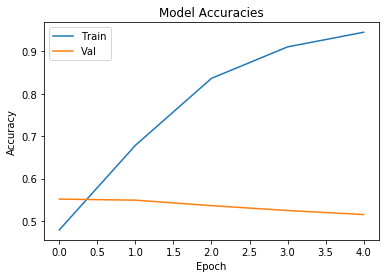

In [11]:
# Plot the history of this model
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

In [12]:
# Load the weights from the model with the best val accuracy
model.load_weights(weightsFilePath)

y_pred = model.predict(x_val)
y_pred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_pred])
y_pred_text = onehot_encoder.inverse_transform(y_pred)
y_val_text = onehot_encoder.inverse_transform(y_val)

In [13]:
def averageFScore(cm):
    (noClasses,_) = cm.shape
    fsum = 0
    recalls = []
    precisions = []
    for i in range(noClasses):
        correct = cm[i][i]
        # if row or col total is zero set to 1 to avoid nans
        rowTotal = max(sum(cm[i]),1)
        colTotal = max(sum(cm[:,i]),1)
        recall = correct / rowTotal
        recalls.append(recall)
        precision = correct / colTotal
        precisions.append(precision)
        
        # Get denominator, if 0 set to 1 to avoid nans
        denominator = precision + recall if precision + recall > 0 else 1
        f1 = 2*precision*recall / denominator
        fsum += f1
    return fsum/noClasses, recalls, precisions

In [14]:
# Create confusion matric
cm = confusion_matrix(y_val_text, y_pred_text)

In [15]:
# Rows are the actual, columns are the predicted. strongly negative,  negative, neutral, positve, strongly positive
print(cm)

[[   0    2   64    9    0]
 [   0   15  750   85    0]
 [   0    9 2556  683    0]
 [   0    1 1575 1654    0]
 [   0    0   71  184    0]]


In [16]:
valAccuracy = (cm[0][0] + cm[1][1] + cm[2][2] +cm[3][3] + cm[4][4])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"valAccuracy {valAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

Average fscore: 0.2437495946359803
valAccuracy 0.5517106294071559
Recalls for each class: [0.0, 0.01764705882352941, 0.7869458128078818, 0.5120743034055728, 0.0]
Precisions for each class [0.0, 0.5555555555555556, 0.5095693779904307, 0.6325047801147228, 0.0]


## Performance on test data

In [17]:
# Load the data
testdf = pd.read_csv('./SemEval2017-task4-test/SemEval2017-task4-test.subtask-CE.english.txt', sep='\t', header=None, keep_default_na=False)
testdf.columns = ['id','topic','label','raw']

testdf['text'] = testdf.apply(lambda row: preprocess(row['raw'], stop_words, row['topic']),axis=1)


/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\ '
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\o'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\_'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\S'
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# Convert text into sequence of numbers
testdf['numSeq'] = testdf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)

In [19]:
x_test = testdf['numSeq']
y_test = testdf['label']

# Prelim analysis to indicate class imbalance
print(y_test.value_counts())

# Onehot encode the y data
y_test = onehot_encoder.transform(np.array(y_test).reshape(len(y_test),1))
x_test = np.array([x for y in x_test for x in y]).reshape(len(x_test),MAXIMUM_LENGTH)

 0    6194
-1    3545
 1    2332
-2     177
 2     131
Name: label, dtype: int64


In [20]:
# Get predictions and prepare data for confusion matrix
y_testpred = model.predict(x_test)
y_testpred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_testpred])
y_testpred_text = onehot_encoder.inverse_transform(y_testpred)
y_test_text = onehot_encoder.inverse_transform(y_test)

In [21]:
# Create confusion matrix and get some key information from it. 
cm = confusion_matrix(y_test_text, y_testpred_text, labels=[-2,-1,0,1,2])
print(cm)
testAccuracy = (cm[0][0] + cm[1][1] + cm[2][2] +cm[3][3] + cm[4][4])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"testAccuracy {testAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

[[   0   15  156    6    0]
 [   0   90 3259  196    0]
 [   0   61 5537  596    0]
 [   0    1 1547  784    0]
 [   0    0   38   93    0]]
Average fscore: 0.22033834022734497
testAccuracy 0.517893206236368
Recalls for each class: [0.0, 0.02538787023977433, 0.893929609299322, 0.3361921097770154, 0.0]
Precisions for each class [0.0, 0.5389221556886228, 0.5254816361393186, 0.46805970149253734, 0.0]


Test accuracy was 51.8%, the drop compared to other subtasks is expected as there are more classes for this task, therefore the challenge is harder. Again the average fscore is low because of the poor precision and recall for the extreme cases of strongly negative and strongly positive. The test and training data have a large class imbalance which makes this problem harder. Future work could improve the model by addressing the class imbalance. 

# Step 4: Improving the classifier
In this section I have tried different models and also different embeddings

In [22]:
# Using different embeddings
# Spacy embeddings. 

def spacyEmbeddings(wordList, nlp):
    spacyList = []
    for word in wordList:
        spacyList.append(nlp(word).vector)
    return spacyList

# Pads the spacy vec to consistent length
def padSpacy(spacyList, MAXIMUM_LENGTH):
    vecSize = len(spacyList[0])
    listLength = len(spacyList)
    zeroVec = np.zeros(vecSize)
    for i in range(MAXIMUM_LENGTH - listLength):
        spacyList.append(zeroVec)
    return np.array(spacyList)

# Load in spacy embeddings and convert all lines to use them
nlp = spacy.load('en_vectors_web_lg')
traindf['spacy'] = traindf.apply(lambda row: spacyEmbeddings(row['text'], nlp),axis=1)

# Get average vecotor for NBOW model. N.B. Doing this before the padding to avoid diluting signal
traindf['spacyAvg'] = traindf.apply(lambda row: np.average(row['spacy'], axis=0),axis=1)

# Trying to use spacy 300 dim vector as a sequence created objects too big for my laptop's memory, 
# therefore couldn't use them as individual embeddings and instead had to average

In [23]:
# Perform split of spacy data into test and val
spacy_x_train, spacy_x_val, spacy_y_train, spacy_y_val = train_test_split(traindf.spacyAvg, traindf.label, stratify=traindf.label, random_state =2)
labelDist = spacy_y_val.value_counts()
print(labelDist)
spacy_x_train = np.array([x for y in spacy_x_train for x in y]).reshape(len(spacy_x_train),300)
spacy_x_val = np.array([x for y in spacy_x_val for x in y]).reshape(len(spacy_x_val),300)
print(spacy_x_train[0].shape)

labelCount = len(labelDist)
#Y data is categorical therefore must be converted to a vector
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
spacy_y_train = onehot_encoder.fit_transform(np.array(spacy_y_train).reshape(len(spacy_y_train),1))
spacy_y_val = onehot_encoder.transform(np.array(spacy_y_val).reshape(len(spacy_y_val),1))

spacy_y_test = testdf['label']
spacy_y_test = onehot_encoder.transform(np.array(spacy_y_test).reshape(len(spacy_y_test),1))
testdf['spacy'] = testdf.apply(lambda row: spacyEmbeddings(row['text'], nlp),axis=1)

# Get average vecotor for NBOW model. N.B. Doing this before the padding to avoid diluting signal
testdf['spacyAvg'] = testdf.apply(lambda row: np.average(row['spacy'], axis=0),axis=1)

spacy_x_test = testdf['spacyAvg']
spacy_x_test = np.array([x for y in spacy_x_test for x in y]).reshape(len(spacy_x_test),300)


 0    3248
 1    3230
-1     850
 2     255
-2      75
Name: label, dtype: int64
(300,)


In [24]:
# This is a NBOW model as it takes the average spacy vector for the sentence and then uses that as an input
spacyModel = Sequential()
spacyModel.add(Dense(64, activation='relu',input_shape=(300,)))
spacyModel.add(Dropout(0.2))
spacyModel.add(Dense(128, activation='relu'))
spacyModel.add(Dropout(0.2))
spacyModel.add(Dense(128, activation='relu'))
spacyModel.add(Dropout(0.2))
spacyModel.add(Dense(64, activation='relu'))
spacyModel.add(Dense(5, activation='softmax'))
spacyModel.summary()

spacyModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Save the best weights to a file so we get the model with the best val acc
spacyWeightsFilePath="task3Spacy.best.hdf5"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
__________

In [25]:
spacyCheckpoint = ModelCheckpoint(spacyWeightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
spaceyHistory = spacyModel.fit(spacy_x_train, spacy_y_train, epochs=30,batch_size=128,validation_data=(spacy_x_val, spacy_y_val), callbacks=[spacyCheckpoint],verbose=1)

Train on 22974 samples, validate on 7658 samples
Epoch 1/30
22974/22974 [==============================] - 1s 57us/step - loss: 1.0768 - acc: 0.5138 - val_loss: 0.9687 - val_acc: 0.5688

Epoch 00001: val_acc improved from -inf to 0.56882, saving model to task3Spacy.best.hdf5
Epoch 2/30
22974/22974 [==============================] - 1s 31us/step - loss: 0.9697 - acc: 0.5638 - val_loss: 0.9446 - val_acc: 0.5831

Epoch 00002: val_acc improved from 0.56882 to 0.58305, saving model to task3Spacy.best.hdf5
Epoch 3/30
22974/22974 [==============================] - 1s 30us/step - loss: 0.9439 - acc: 0.5741 - val_loss: 0.9314 - val_acc: 0.5837

Epoch 00003: val_acc improved from 0.58305 to 0.58370, saving model to task3Spacy.best.hdf5
Epoch 4/30
22974/22974 [==============================] - 1s 33us/step - loss: 0.9323 - acc: 0.5776 - val_loss: 0.9295 - val_acc: 0.5783

Epoch 00004: val_acc did not improve from 0.58370
Epoch 5/30
22974/22974 [==============================] - 1s 34us/step - los

In [26]:
# Load the weights from the model with the best val accuracy
spacyModel.load_weights(spacyWeightsFilePath)

# Get predictions and prepare data for confusion matrix
spacy_y_testpred = spacyModel.predict(spacy_x_test)
spacy_y_testpred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in spacy_y_testpred])
spacy_y_testpred_text = onehot_encoder.inverse_transform(spacy_y_testpred)
spacy_y_test_text = onehot_encoder.inverse_transform(spacy_y_test)

In [27]:
# Create confusion matrix and get some key information from it. 
cm = confusion_matrix(spacy_y_test_text, spacy_y_testpred_text, labels=[-2,-1,0,1,2])
print(cm)
testAccuracy = (cm[0][0] + cm[1][1] + cm[2][2] +cm[3][3] + cm[4][4])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"testAccuracy {testAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

[[   0  124   49    4    0]
 [   0 1409 1956  180    0]
 [   0  765 4788  641    0]
 [   0   78 1153 1101    0]
 [   0    2   12  117    0]]
Average fscore: 0.3311480349766879
testAccuracy 0.5895468131513046
Recalls for each class: [0.0, 0.39746121297602255, 0.7730061349693251, 0.47212692967409947, 0.0]
Precisions for each class [0.0, 0.5925147182506307, 0.6016587082181453, 0.5389133627019089, 0.0]


Spacy NBOW method gets 58.4% validation accuracy and 59.0% test accuracy. This performance is similar to the LSTM at validation but outperforms the LSTM for test accuracy and test fscore. I believe the test performance improvement is largely due to the large number of dropout layers, which help defend against overfitting. This has made the Spacy NBOW model more robust than the LSTM. The Spacy NBOW model also takes much less time to train so might be more useful for real world applications that may require fast training/processing. Multiple architectures were experimented with before settling on this architecture, including much deeper networks, much wider networks, networks without dropout.

## Step 4: Alternative model2: CNN
In this I try a CNN model to see if that can improve the accuracy using learnt embeddings

In [28]:
# Perform transfer learning to transfer weights learnt from original model to accelerate learning
model.load_weights(weightsFilePath)
embeddingLayer = model.get_layer(index=0)
embeddingLayer.trainable=False # Massively Reduce number of trainable weights which may help reduce overfitting

# Create CNN model
cnnModel = Sequential()
cnnModel.add(embeddingLayer)
cnnModel.add(Conv1D(64, 3))
cnnModel.add(Dropout(0.5))
cnnModel.add(MaxPooling1D(3))
cnnModel.add(Flatten()) # Required to get vector rather than matrix/tensor out
cnnModel.add(Dense(128, activation='relu'))
cnnModel.add(Dropout(0.5))
cnnModel.add(Dense(64, activation='relu'))
cnnModel.add(Dense(5, activation='softmax'))
cnnModel.summary()

cnnModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Save the best weights to a file so we get the model with the best val acc
cnnWeightsFilePath="task3CNN.best.hdf5"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 64)            19264     
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

In [29]:
# Checkpoint and train model 
cnnCheckpoint = ModelCheckpoint(cnnWeightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
cnnHistory = cnnModel.fit(x_train, y_train, epochs=20,batch_size=128,validation_data=(x_val, y_val), callbacks=[cnnCheckpoint],verbose=1)

Train on 22974 samples, validate on 7658 samples
Epoch 1/20
22974/22974 [==============================] - 4s 167us/step - loss: 0.9418 - acc: 0.6108 - val_loss: 1.0104 - val_acc: 0.5560

Epoch 00001: val_acc improved from -inf to 0.55602, saving model to task3CNN.best.hdf5
Epoch 2/20
22974/22974 [==============================] - 2s 83us/step - loss: 0.7889 - acc: 0.6961 - val_loss: 1.0380 - val_acc: 0.5521

Epoch 00002: val_acc did not improve from 0.55602
Epoch 3/20
22974/22974 [==============================] - 2s 81us/step - loss: 0.7384 - acc: 0.7191 - val_loss: 1.0626 - val_acc: 0.5500

Epoch 00003: val_acc did not improve from 0.55602
Epoch 4/20
22974/22974 [==============================] - 2s 83us/step - loss: 0.7022 - acc: 0.7364 - val_loss: 1.0740 - val_acc: 0.5437

Epoch 00004: val_acc did not improve from 0.55602
Epoch 5/20
22974/22974 [==============================] - 2s 80us/step - loss: 0.6807 - acc: 0.7442 - val_loss: 1.1011 - val_acc: 0.5380

Epoch 00005: val_acc di

Main issue with the CNN has been overfitting, Adding dropout layers and maxpooling has not helped. Architectures that used multiple conv layers to reduce the trainable dimensions also did not help. There is a ~20% diff between training and val accuracies from the start and that only increases as training continues. Experiments with different architectures and with non-trainable vs trainable embeddings did not yield signifcant improvements. The best validation accuracy was 55.6%. This is similar to the LSTM and is much faster to train, the overfitting remains its main challenge. As the val accuracy for this model was lower than NBOW I did not apply it to the test data. 

## Step4: Model 3: Bidirectional LSTM
For my third attempt at improving the performance i tried changing the model to the bidirectional LSTM

In [30]:
# Create bilstm
bilstmModel = Sequential()
bilstmModel.add(Embedding(VOCAB_SIZE, EMBED_SIZE,input_length=MAXIMUM_LENGTH))
bilstmModel.add(Bidirectional(LSTM(128)))
bilstmModel.add(Dropout(0.5))
bilstmModel.add(Dense(labelCount, activation='softmax'))
bilstmModel.summary()

bilstmModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
bilstmWeightsFilePath="task3bilstm.best.hdf5"



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 1285      
Total params: 6,235,781
Trainable params: 6,235,781
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Save the best weights to a file so we get the model with the best val acc
bilstmCheckpoint = ModelCheckpoint(bilstmWeightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
bilstmHistory = bilstmModel.fit(x_train,y_train,epochs=5,batch_size=128,validation_data=(x_val, y_val), callbacks=[bilstmCheckpoint],verbose=1)

Train on 22974 samples, validate on 7658 samples
Epoch 1/5
22974/22974 [==============================] - 35s 2ms/step - loss: 1.1227 - acc: 0.4736 - val_loss: 0.9969 - val_acc: 0.5632

Epoch 00001: val_acc improved from -inf to 0.56320, saving model to task3bilstm.best.hdf5
Epoch 2/5
22974/22974 [==============================] - 32s 1ms/step - loss: 0.8284 - acc: 0.6649 - val_loss: 1.0103 - val_acc: 0.5652

Epoch 00002: val_acc improved from 0.56320 to 0.56516, saving model to task3bilstm.best.hdf5
Epoch 3/5
22974/22974 [==============================] - 30s 1ms/step - loss: 0.5017 - acc: 0.8168 - val_loss: 1.1813 - val_acc: 0.5406

Epoch 00003: val_acc did not improve from 0.56516
Epoch 4/5
22974/22974 [==============================] - 31s 1ms/step - loss: 0.2887 - acc: 0.8988 - val_loss: 1.4935 - val_acc: 0.5276

Epoch 00004: val_acc did not improve from 0.56516
Epoch 5/5
22974/22974 [==============================] - 30s 1ms/step - loss: 0.1897 - acc: 0.9354 - val_loss: 1.7255 - 

In [32]:
# Load the weights from the model with the best val accuracy
bilstmModel.load_weights(bilstmWeightsFilePath)

bilstm_y_test_pred = bilstmModel.predict(x_test)
bilstm_y_test_pred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in bilstm_y_test_pred])
bilstm_y_test_pred_text = onehot_encoder.inverse_transform(bilstm_y_test_pred)
y_test_text = onehot_encoder.inverse_transform(y_test)

In [33]:
# Create confusion matrix and get some key information from it. 
cm = confusion_matrix(y_test_text, bilstm_y_test_pred_text, labels=[-2,-1,0,1,2])
print(cm)
testAccuracy = (cm[0][0] + cm[1][1] + cm[2][2] +cm[3][3] + cm[4][4])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"testAccuracy {testAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

[[   0   88   76   13    0]
 [   0  771 2371  402    1]
 [   0  490 4450 1254    0]
 [   0   80 1071 1179    2]
 [   0    7   18  105    1]]
Average fscore: 0.27964083520996447
testAccuracy 0.5170853865417239
Recalls for each class: [0.0, 0.21748942172073343, 0.7184371972876977, 0.5055746140651801, 0.007633587786259542]
Precisions for each class [0.0, 0.536908077994429, 0.5572251440020035, 0.39925499492041994, 0.25]


The bidirectional LSTM makes only a small improvement on the LSTM. It has a validation accuracy of 52.1% and a test accuracy of 51.8%. The NBOW remains the strongest model despite it using only the average word vector, meaning it ignores the sequences of words. 